In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statistics as stats
from datetime import datetime
from pandas_datareader import data
import time

In [198]:
import category_encoders as ce      #Have to first install with "pip install category_encoders"

In [229]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [2]:
import sys 
print (sys.version) 

3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
pd.set_option("display.precision", 3)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

In [4]:
df2018 = pd.read_csv("ks-projects-201801.csv", parse_dates=True, infer_datetime_format=True, 
                  usecols=["ID", "name", "category", "main_category", "currency", "deadline", "goal", "launched"
                          , "pledged", "state", "backers", "country"])
df2018["Date"] = "January 2018"

In [5]:
#df2016 = pd.read_csv("ks-projects-201612.csv", engine='python', parse_dates=True, infer_datetime_format=True, 
#                  usecols=[0,1,2,3,4,5,6,7,8,9,10,11], header=None, skiprows=1, 
#                      names=['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
#       'goal', 'launched', 'pledged', 'state', 'backers', 'country'])
df2016 = pd.read_csv("ks-projects-201612.csv", engine='python', parse_dates=True, infer_datetime_format=True)
df2016["Date"] = "December 2016"

In [6]:
print(df2018.shape)
print("\n")
print(df2016.shape)

(378661, 13)


(323750, 18)


In [7]:
df2016.columns

Index(['ID ', 'name ', 'category ', 'main_category ', 'currency ', 'deadline ',
       'goal ', 'launched ', 'pledged ', 'state ', 'backers ', 'country ',
       'usd pledged ', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'Date'],
      dtype='object')

In [8]:
#Renaming DF2016 columns to remove the extra space and giving proper names to the Unnamed columns

df2016.rename(columns={'ID ': 'ID', 'name ': 'name', 'category ': 'category', 'main_category ': 'main_category',
                      'currency ': 'currency', 'deadline ': 'deadline', 'goal ': 'goal', 'launched ': 'launched', 
                      'pledged ': 'pledged', 'state ': 'state', 'backers ': 'backers', 'country ': 'country', 
                      'usd_pledged ': 'usd_pledged', 'Unnamed: 13':'E1', 'Unnamed: 14': 'E2', 
                      'Unnamed: 15': 'E3', 'Unnamed: 16':'E4'}, inplace=True)

In [9]:
#Looking up for rows where E1 <> NULL, and concatenating Name and Category for those rows

df2016.loc[df2016['E1'].notna(), ['name']] = df2016["name"] + df2016["category"]


In [10]:
df2016_copy = df2016

In [11]:
df2016[df2016["E1"].notna()].shape

(625, 18)

In [12]:
list_cols = df2016.columns.drop(['ID', 'name']).tolist()
list_cols

['category',
 'main_category',
 'currency',
 'deadline',
 'goal',
 'launched',
 'pledged',
 'state',
 'backers',
 'country',
 'usd pledged ',
 'E1',
 'E2',
 'E3',
 'E4',
 'Date']

In [13]:
# For all the rows where E1 <> NULL --> shift the values leftwards, for all columns in [Category:Date] range

for i in range(0, len(list_cols)-1):
    df2016.loc[df2016["E1"].notna(), list_cols[i]] = df2016.loc[df2016["E1"].notna(), list_cols[i+1]]

In [14]:
df2016[df2016["E1"].notna()].shape

(12, 18)

In [15]:
df2016.state.unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended', '20', '0', '26', '7470', '3280',
       '2012-06-06 23:54:14', '1', '6323', '2015-07-03 18:23:23', '2503',
       '435', '401', '2014-02-05 02:06:20', '750', '88619.2'],
      dtype=object)

In [16]:
# Getting a list of all "garbage" values of "state" --> these would be the rows to be deleted

list_states = df2016.state.unique().tolist()
len(list_states)
list_states = list_states[6:]
list_states

['20',
 '0',
 '26',
 '7470',
 '3280',
 '2012-06-06 23:54:14',
 '1',
 '6323',
 '2015-07-03 18:23:23',
 '2503',
 '435',
 '401',
 '2014-02-05 02:06:20',
 '750',
 '88619.2']

In [17]:
# Deleting the aforementioned rows that contain a garbage value for "State"

df2016 = df2016.drop(df2016[df2016["state"].isin(list_states)].index)

In [18]:
df2016["goal"] = pd.to_numeric(df2016["goal"])
df2016["pledged"] = pd.to_numeric(df2016["pledged"])
df2016["backers"] = pd.to_numeric(df2016["backers"])

In [19]:
df_fulldata = pd.concat([df2018, df2016], keys='ID', ignore_index=True, sort=True)

In [20]:
df_fulldata.columns

Index(['Date', 'E1', 'E2', 'E3', 'E4', 'ID', 'backers', 'category', 'country',
       'currency', 'deadline', 'goal', 'launched', 'main_category', 'name',
       'pledged', 'state', 'usd pledged '],
      dtype='object')

In [21]:
print(df_fulldata.E4.unique())

[nan]


In [22]:
df_fulldata = df_fulldata.drop(["E1", "E2", "E3", "E4"], axis=1)

In [23]:
df_fulldata.columns

Index(['Date', 'ID', 'backers', 'category', 'country', 'currency', 'deadline',
       'goal', 'launched', 'main_category', 'name', 'pledged', 'state',
       'usd pledged '],
      dtype='object')

In [24]:
#print(df.loc[df['A'] == 'foo'])

df_fulldata.loc[df_fulldata['ID'] == 1495637387]

,Date,ID,backers,category,country,currency,deadline,goal,launched,main_category,name,pledged,state,usd pledged
97593,January 2018,1495637387,4,Documentary,US,USD,2011-05-16,7777.00,2011-03-15 03:08:19,Film & Video,From Lashes to Liberty; The Power of a Photograph,255.00,failed,NaN
462131,December 2016,1495637387,4,Documentary,US,USD,2011-05-16 03:58:00,7777.00,2011-03-15 03:08:19,Film & Video,From Lashes to Liberty The Power of a Photograph,255.00,failed,255


In [25]:
#Converting the two Date columns to the date format

df_fulldata.deadline = pd.to_datetime(df_fulldata.deadline, format='%Y-%m-%d')
df_fulldata.launched = pd.to_datetime(df_fulldata.launched, format='%Y-%m-%d')

In [26]:
#Measuring the project duration - need only the "number of days"

df_fulldata['duration'] = (df_fulldata.deadline - df_fulldata.launched).dt.days

In [27]:
list_currency = df_fulldata.currency.unique().tolist()
list_forex = []

In [28]:
# list_forex = <<Get forex rates using DataReader for the list_currency members>>
counter = 0
list_forex.clear()
for members in list_currency:
    rate = data.DataReader(members+"/USD", data_source="av-forex", access_key='X3ELXPQMHTY9BQ7E')
    list_forex.append(rate.iloc[4][0])       
    #print(rate.iloc[4])
    counter = counter+1
    if counter == 5:
        counter = 0
        time.sleep(60)
        
# "rate" is the Dataframe returned by DataReader() with all the exchange variables - the headers are the indices
# and the actual values are in a single column denoted by name - <<currency_x>>/USD 
#rate.iloc[4] refers to "Exchange Rate" in the Dataframe "rate", which is returned as a Series with just 1 element
#rate.iloc[4][0] points to the first element in the series, which is the actual float value of the Exchange rate
#time.sleep(60) is used to pause for 1 minute, as the free api_key for DataReader - "av-forex" only allows 5 API
# requests per minute

In [29]:
#Creating Dataframe from 2 lists - Method 1 - Using list(zip(list1, list2)) method

data_forex_rates = pd.DataFrame(list(zip(list_currency, list_forex)), columns=["Curr", "Rate"])
data_forex_rates.rename({"Curr":"currency"}, axis=1, inplace=True)
data_forex_rates.head()

,currency,Rate
0,GBP,1.35480000
1,USD,1.00000000
2,CAD,0.77660000
3,AUD,0.75994000
4,NOK,0.11573000


In [30]:
#Alternative method to create DataFrame from 2 lists

data_dict = {"Curr": list_currency, "Rates":list_forex}   #Define Data Dictionary
data_forex_rates2 = pd.DataFrame(data_dict, columns=["Curr", "Rates"])  #Create DataFrame from the data_dict
data_forex_rates2.head()

,Curr,Rates
0,GBP,1.35480000
1,USD,1.00000000
2,CAD,0.77660000
3,AUD,0.75994000
4,NOK,0.11573000


In [31]:
#count_of_states = df1[['state', 'name']].groupby(['state']).count()
#count_of_categories = df1[['category', 'name']].groupby(['category']).count()
#count_of_maincategory = df1[['main_category', 'name']].groupby(['main_category']).count()

In [32]:
df_fulldata["backers"] = pd.to_numeric(df_fulldata["backers"])

In [33]:
avg_backers_by_state = df_fulldata[["state", "backers"]].groupby(["state"]).mean()
avg_backers_by_state

,backers
state,
canceled,25.61
failed,16.58
live,75.50
successful,259.11
suspended,108.98
undefined,0.00


In [34]:
df_fulldata.loc[df_fulldata["country"]=="N,\"0"]

,Date,ID,backers,category,country,currency,deadline,goal,launched,main_category,name,pledged,state,usd pledged,duration
378811,December 2016,1000694855,0,Film & Video,"N,""0",USD,2014-09-20 06:59:00,6500.00,2014-08-06 21:28:36,Film & Video,STREETFIGHTERZ WHEELIE MURICA,555.00,undefined,NaN,44
378948,December 2016,100149523,0,Music,"N,""0",AUD,2015-08-25 23:00:00,4500.00,2015-08-04 12:05:17,Music,Duncan Woods - Chameleon EP,4767.00,undefined,NaN,21
379210,December 2016,1003023003,0,Music,"N,""0",USD,2015-04-09 21:06:13,3500.00,2015-03-10 20:06:13,Music,The Making of Ashley Kelley's Debut Album,3576.00,undefined,NaN,30
379222,December 2016,1003130892,0,Music,"N,""0",USD,2015-11-26 10:59:00,6000.00,2015-11-02 22:09:19,Music,Butter Side Down Debut Album,7007.80,undefined,NaN,23
379311,December 2016,1003629045,0,Music,"N,""0",USD,2016-03-21 06:00:00,3000.00,2016-02-23 03:09:49,Music,Chase Goehring debut EP,3660.38,undefined,NaN,27
379375,December 2016,1004013077,0,Music,"N,""0",CAD,2014-10-10 22:51:01,4000.00,2014-09-10 22:51:01,Music,Spencer Capier Instrumental Project 2015,4760.00,undefined,NaN,30
379391,December 2016,1004126342,0,Music,"N,""0",USD,2015-06-11 04:00:00,5000.00,2015-05-15 02:12:35,Music,LUKAS LIGETI'S 50TH BIRTHDAY FESTIVAL: ORIGINA...,6370.00,undefined,NaN,27
379408,December 2016,1004255433,0,Film & Video,"N,""0",USD,2015-11-07 08:59:00,6000.00,2015-10-10 18:45:24,Film & Video,The Battle For Breukelen: A Neighborhood Epic,6695.00,undefined,NaN,27
379412,December 2016,1004298993,0,Music,"N,""0",USD,2015-03-28 18:28:27,2750.00,2015-02-11 19:28:27,Music,"""Tamboura Plays Violin"" - a collection of Pop ...",2926.00,undefined,NaN,44
379426,December 2016,1004402863,0,Music,"N,""0",USD,2015-12-11 21:02:55,1200.00,2015-11-11 21:02:55,Music,Nightingale Noel - An A Cappella Holiday CD,1585.00,undefined,NaN,30


In [35]:
df_fulldata.drop(df_fulldata[df_fulldata["country"] == "N,\"0"].index, inplace=True)

In [36]:
#Looking at the state distribution of projects by Category

grouping1 = df_fulldata.groupby(["state", "country"], as_index=False)["backers"].mean()
grouping1.head()

,state,country,backers
0,canceled,AT,21.32
1,canceled,AU,19.53
2,canceled,BE,12.90
3,canceled,CA,23.88
4,canceled,CH,25.64


In [37]:
grouping2 = df_fulldata[["state", "main_category", "backers"]].groupby(["state", "main_category"])["backers"].mean()
grouping2.head()

state     main_category
canceled  Art              7.17
          Comics          18.78
          Crafts           7.09
          Dance            6.23
          Design          42.40
Name: backers, dtype: float64

In [38]:
#survivors = df2[['Survived', 'Pclass', 'Sex', 'Traveling']].groupby(['Pclass', 'Sex', 'Traveling']).mean()


grouping3 = df_fulldata[["main_category","country","state"]].groupby(["main_category", "country"]).count()
grouping3.head(5)


state
main_category country       
Art           AT          57
              AU         745
              BE          75
              CA        1945
              CH          79

In [39]:
left_join1 = pd.merge(df_fulldata, data_forex_rates, on="currency", how="inner")

In [217]:
df_tempdata = df_fulldata.copy()
df_tempdata.loc[:, "currency"] = df_tempdata["currency"].map(data_forex_rates)
df_tempdata.head()

TypeError: 'DataFrame' object is not callable

In [40]:
df_fulldata.loc[df_fulldata["ID"]==1000002330]

,Date,ID,backers,category,country,currency,deadline,goal,launched,main_category,name,pledged,state,usd pledged,duration
0,January 2018,1000002330,0,Poetry,GB,GBP,2015-10-09 00:00:00,1000.00,2015-08-11 12:12:28,Publishing,The Songs of Adelaide & Abullah,0.00,failed,NaN,58
378661,December 2016,1000002330,0,Poetry,GB,GBP,2015-10-09 11:36:00,1000.00,2015-08-11 12:12:28,Publishing,The Songs of Adelaide & Abullah,0.00,failed,0,58


In [41]:
df_fulldata.loc[(df_fulldata["backers"]==0) & (df_fulldata["state"]=="successful")]

,Date,ID,backers,category,country,currency,deadline,goal,launched,main_category,name,pledged,state,usd pledged,duration
2457,January 2018,1012744036,0,Music,"N,0""",USD,2016-05-26,5000.00,2016-04-26 19:46:26,Music,An Oratorio for our Time - Last Stop Cafe,5170.00,successful,NaN,29
4892,January 2018,1024989802,0,Music,"N,0""",USD,2016-05-11,5000.00,2016-04-11 19:29:17,Music,Jackson Ruby: The Cassette Album,5296.00,successful,NaN,29
5353,January 2018,1027275369,0,Music,"N,0""",USD,2016-05-21,3800.00,2016-04-21 16:14:28,Music,Help Parker Brown make his first solo album,5077.00,successful,NaN,29
5597,January 2018,1028691308,0,Music,"N,0""",USD,2016-05-08,3500.00,2016-04-04 23:32:00,Music,Help BETHANY record a NEW single in Nash!,3502.13,successful,NaN,33
8260,January 2018,1041708793,0,Music,"N,0""",USD,2016-05-01,3500.00,2016-03-25 17:20:21,Music,Serena Gabriel's first CD!!!!!!: Diving Deep,3787.00,successful,NaN,36
13001,January 2018,1065249597,0,Hardware,"N,0""",USD,2014-06-15,200000.00,2014-04-29 17:18:03,Technology,SCiO: Your Sixth Sense. A Pocket Molecular Sen...,2762571.78,successful,NaN,46
13048,January 2018,1065509232,0,Music,"N,0""",GBP,2016-05-12,3500.00,2016-04-11 12:42:02,Music,LUME Festival 2016,3606.00,successful,NaN,30
14527,January 2018,1073104639,0,Music,"N,0""",CAD,2016-05-04,4000.00,2016-03-25 16:56:43,Music,SUNN - EP - Pre-vente,4051.00,successful,NaN,39
16769,January 2018,1084993156,0,Music,"N,0""",USD,2013-04-09,3750.00,2013-03-26 05:06:11,Music,"Willy Tea, Chris Doud and Chums: The Children'...",4593.00,successful,NaN,13
21385,January 2018,110837091,0,Music,"N,0""",USD,2016-05-07,8000.00,2016-03-28 20:38:22,Music,Nathan Menard,8263.45,successful,NaN,39


In [42]:
left_join1.loc[left_join1["ID"]==1379649454]

,Date,ID,backers,category,country,currency,deadline,goal,launched,main_category,name,pledged,state,usd pledged,duration,Rate
119804,January 2018,1379649454,0,Music,"N,0""",USD,2013-04-11,5000.00,2013-03-02 15:50:25,Music,"Juiette Z. Payne presents debut EP ""Eternal Da...",5250.00,successful,NaN,39,1.00000000


In [43]:
left_join1.iloc[120263,11] - left_join1.iloc[120263,7]

-2984.0

In [44]:
left_join1["size"] = ''

In [45]:
#Sort the dataframe based on data, to set stage for the drop_duplicates() later
left_join1.sort_values("Date", inplace = True)

In [46]:
#Drop duplicate rows based on ID, and keep the last row of the duplicates - the one from January 2018
left_join2 = left_join1.drop_duplicates(subset="ID", keep="last")

In [47]:
left_join2.loc[left_join2["ID"]==1379649454]

,Date,ID,backers,category,country,currency,deadline,goal,launched,main_category,name,pledged,state,usd pledged,duration,Rate,size
119804,January 2018,1379649454,0,Music,"N,0""",USD,2013-04-11,5000.00,2013-03-02 15:50:25,Music,"Juiette Z. Payne presents debut EP ""Eternal Da...",5250.00,successful,NaN,39,1.00000000,


In [48]:
df = left_join2.copy()
del left_join2

In [49]:
df["goal"] = pd.to_numeric(df["goal"])
#df.goal.astype("float", inplace=True)

In [50]:
df.loc[df['goal']<1000, 'size'] = "small"


In [51]:
df.loc[df["goal"]<1000]

,Date,ID,backers,category,country,currency,deadline,goal,launched,main_category,name,pledged,state,usd pledged,duration,Rate,size
620617,January 2018,1694616421,45,Video Games,CA,CAD,2015-11-27,100.00,2015-10-28 20:35:16,Games,Major\Minor,711.00,successful,NaN,29,0.77660000,small
620624,January 2018,1695417098,4,Comics,CA,CAD,2015-07-01,750.00,2015-06-01 23:25:50,Comics,The Cunning Conjurer,160.00,failed,NaN,29,0.77660000,small
620625,January 2018,1696089599,1,Art,CA,CAD,2017-03-09,750.00,2017-02-07 04:26:44,Art,A Visual Culture: a monthly art subscription,35.00,canceled,NaN,29,0.77660000,small
620659,January 2018,1700357678,0,Apparel,CA,CAD,2015-04-05,500.00,2015-03-06 06:42:32,Fashion,Future Skeleton,0.00,failed,NaN,29,0.77660000,small
620673,January 2018,170152217,1,Graphic Design,CA,CAD,2014-08-14,30.00,2014-07-15 00:31:40,Design,Tee Shirt Design,42.00,successful,NaN,29,0.77660000,small
620680,January 2018,1702218630,1,Nature,CA,CAD,2016-04-04,800.00,2016-03-05 00:02:29,Photography,Capturing Iceland (Canceled),20.00,canceled,NaN,29,0.77660000,small
620635,January 2018,1697695514,39,Poetry,CA,CAD,2016-12-04,750.00,2016-10-25 09:24:44,Publishing,Heal & Conquer Poetry Chapter Book!,1495.00,successful,NaN,39,0.77660000,small
620639,January 2018,1698051460,45,Illustration,CA,CAD,2018-01-11,200.00,2017-12-22 22:32:33,Art,5$ Artwork,1613.00,live,NaN,19,0.77660000,small
620655,January 2018,170021608,0,Jewelry,CA,CAD,2016-04-01,500.00,2016-03-07 18:48:42,Fashion,Mother's Day! EXCLUSIVE EDITION Morse Secret C...,0.00,failed,NaN,24,0.77660000,small
620647,January 2018,1698670816,5,Publishing,CA,CAD,2017-12-18,100.00,2017-11-18 21:42:44,Publishing,2018 BUDGET Passion Planner 172 PRINTABLE page...,29.00,failed,NaN,29,0.77660000,small


In [52]:
df.drop(["name", "usd pledged "], axis=1, inplace=True)

In [53]:
df.pledged = pd.to_numeric(df.pledged)
df.backers = pd.to_numeric(df.backers)
df.Rate = pd.to_numeric(df.Rate)

In [54]:
df["goal_usd"] = df.goal * df.Rate
df["pledged_usd"] = df.pledged * df.Rate

In [55]:
df.loc[df["state"]=="successful", "result"] = "hit"
df["result"].fillna("miss", inplace=True)

In [130]:
df["Delta"] = df["pledged_usd"] - df["goal_usd"]

In [131]:
df.isna().sum()

Date             0
ID               0
backers          0
category         0
country          0
currency         0
deadline         0
goal             0
launched         0
main_category    0
pledged          0
state            0
duration         0
Rate             0
size             0
goal_usd         0
pledged_usd      0
result           0
Delta            0
dtype: int64

In [57]:
df["size"].unique()

array(['', 'small'], dtype=object)

In [168]:
df.groupby("result")["goal",].mean()

,goal
result,
hit,10162.96
miss,70385.13


In [ ]:
a_plot = sns.boxplot(x='result', y='goal', data=df, notch=True)
a_plot = sns.swarmplot(x='result', y='goal', data=df)
#xlim=(0, 45)
a_plot.set(ylim=(0, 80000))
plt.show()

In [ ]:
df.groupby("result").agg({"backers":['sum','mean','count', 'max', 'std', 'median']}).round(1)

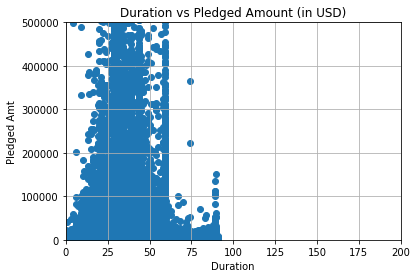

In [190]:
plt.scatter(x=df.duration, y=df.pledged_usd)
plt.grid(True)
plt.title("Duration vs Pledged Amount (in USD)")
plt.xlabel("Duration")
plt.ylabel("Pledged Amt")
plt.xlim(0,200)
plt.ylim(0,500000)
plt.show()

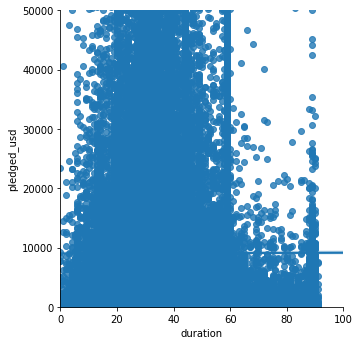

In [128]:
b_plot = sns.lmplot("duration", "pledged_usd", df)
b_plot.set(xlim = (0,200))
b_plot.set(ylim = (0, 500000))
plt.show()

In [132]:
df[["duration", "goal", "pledged", "backers", "Delta"]].describe()

,duration,goal,pledged,backers,Delta
count,378661.00,378661.00,378661.00,378661.00,378661.00
mean,33.48,49080.79,9682.98,105.62,-36189.10
std,65.91,1183391.26,95636.01,907.19,1146052.35
min,0.00,0.01,0.00,0.00,-135480000.00
25%,29.00,2000.00,30.00,2.00,-9999.00
50%,29.00,5200.00,620.00,12.00,-1965.00
75%,36.00,16000.00,4076.00,56.00,198.81
max,16738.00,100000000.00,20338986.27,219382.00,19838986.27


In [138]:
delta_q1 = np.percentile(df.Delta, 25)
delta_q3 = np.percentile(df.Delta, 75)
print("Delta Q1:", delta_q1)
print("Delta Q3:", delta_q3)

Delta Q1: -9999.0
Delta Q3: 198.80960000000005


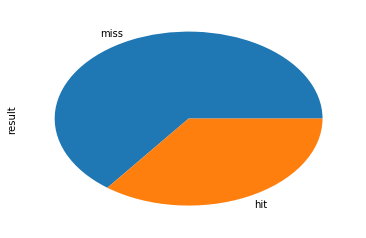

In [66]:
projDist = df["result"].value_counts()
projDist.plot(kind="pie")

In [88]:
#countryDistr = df.groupby(["country", "result"], as_index=False)["result"].count()
#countryDistr
#countryDist.plot(kind="bar")

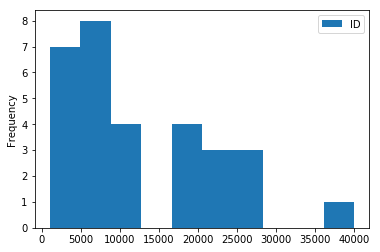

In [182]:
results_by_cat = df.groupby(["result", "main_category"], as_index=False)["ID"].count()
results_by_cat.plot(x="main_category", y="ID", kind="hist")

In [189]:
#Attempting to find out reasonable outlier limits for each of the numerical features
print("Backers < 5000 :\t", df.backers[df.backers>5000].count())
print("Goal (USD) >10000 :", df.goal[df.goal_usd>100000].count())
print("Duration > 100 :\t", df.duration[df.duration>100].count())
print("Pledged (USD) >50000 :", df.pledged[df.pledged_usd>50000].count())

Backers < 5000 :	 773
Goal (USD) >10000 : 12651
Duration > 100 :	 7
Pledged (USD) >50000 : 10541


In [196]:
print("Pledged (USD) for HITS::")
print("MEAN: ", df.loc[df.result=='hit', "pledged_usd"].mean())
print("MEDIAN: ", df.loc[df.result=='hit', "pledged_usd"].median())
print("STANDARD DEVIATION: ", df.loc[df.result=='hit', "pledged_usd"].std())

print("\n\nPledged (USD) for MISSES::")
print("MEAN: ", df.loc[df.result=='miss', "pledged_usd"].mean())
print("MEDIAN: ", df.loc[df.result=='miss', "pledged_usd"].median())
print("STANDARD DEVIATION: ", df.loc[df.result=='miss', "pledged_usd"].std())

Pledged (USD) for HITS::
MEAN:  22629.105843410165
MEDIAN:  5090.25
STANDARD DEVIATION:  151121.45907367705


Pledged (USD) for MISSES::
MEAN:  1598.7215186529531
MEDIAN:  100.0
STANDARD DEVIATION:  12354.358293282456


In [205]:
bin_encoder1 = ce.BinaryEncoder(cols=["category"])
df_codes_cat = bin_encoder1.fit_transform(df["category"])
df_encoded_temp = pd.concat([df, df_codes_cat], axis=1)


In [210]:
bin_encoder2 = ce.BinaryEncoder(cols=["main_category"])
df_codes_maincat = bin_encoder2.fit_transform(df["main_category"])
df_encoded = pd.concat([df_encoded_temp, df_codes_maincat], axis=1)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 620463 to 698601
Data columns (total 33 columns):
Date               378661 non-null object
ID                 378661 non-null int64
backers            378661 non-null int64
category           378661 non-null object
country            378661 non-null object
currency           378661 non-null object
deadline           378661 non-null datetime64[ns]
goal               378661 non-null float64
launched           378661 non-null datetime64[ns]
main_category      378661 non-null object
pledged            378661 non-null float64
state              378661 non-null object
duration           378661 non-null int64
Rate               378661 non-null float64
size               378661 non-null object
goal_usd           378661 non-null float64
pledged_usd        378661 non-null float64
result             378661 non-null object
Delta              378661 non-null float64
category_0         378661 non-null int64
category_1         378661 

In [214]:
df_encoded.drop(["ID", "Date", "goal", "pledged", "state", "launched", "deadline", "size"], axis=1, inplace=True)

In [215]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 620463 to 698601
Data columns (total 25 columns):
backers            378661 non-null int64
category           378661 non-null object
country            378661 non-null object
currency           378661 non-null object
main_category      378661 non-null object
duration           378661 non-null int64
Rate               378661 non-null float64
goal_usd           378661 non-null float64
pledged_usd        378661 non-null float64
result             378661 non-null object
Delta              378661 non-null float64
category_0         378661 non-null int64
category_1         378661 non-null int64
category_2         378661 non-null int64
category_3         378661 non-null int64
category_4         378661 non-null int64
category_5         378661 non-null int64
category_6         378661 non-null int64
category_7         378661 non-null int64
category_8         378661 non-null int64
main_category_0    378661 non-null int64
main_categ

In [227]:
df_cntry_cats = df[["country", "main_category", "duration", "pledged_usd", "backers"]].groupby(["country", "main_category"], as_index=False).agg(["mean", "count"])

In [228]:
df_cntry_cats.head(20)

duration       pledged_usd       backers      
                          mean count        mean count    mean count
country main_category                                               
AT      Art              33.55    40     4092.73    40   33.88    40
        Comics           30.50     6     6698.19     6  100.50     6
        Crafts           33.46    13     1651.89    13    6.00    13
        Dance            28.67     3     2980.45     3   24.67     3
        Design           33.95    82    73393.19    82  418.73    82
        Fashion          31.76    37     7803.32    37   64.11    37
        Film & Video     35.33    51     4404.39    51   21.29    51
        Food             34.36    42     2364.07    42   13.45    42
        Games            32.84    69     7259.00    69  134.62    69
        Journalism       33.27    11       44.73    11    2.91    11
        Music            35.35    37     1650.42    37   18.81    37
        Photography      35.27    30     3230.79    30   29.07    30
        Publishing       34.10    39     2268.05    39   42.10    39
        Technology       35.21   130    20977.02   130   93.35   130
        Theater          26.86     7     1783.33     7   14.71     7
AU      Art              31.92   425     2111.78   425   31.60   425
        Comics           32.21   188     2037.09   188   73.53   188
        Crafts           30.90   183      792.47   183   14.44   183
        Dance            29.56    32     1954.01    32   18.69    32
        Design           33.06   929    15227.25   929  203.76   929

Steps for ML algorithms:

1. Apply binary classification and logistic regression algorithms to the current dataset - df_encoded
2. Test the performance
3. Go back to feature engineering - standardization (StandardScalar) of all 4 of the numerical features
4. Reapply the same algorithms on the new dataset
5. Retest the performance

In [230]:
df_encoded.columns

Index(['backers', 'category', 'country', 'currency', 'main_category',
       'duration', 'Rate', 'goal_usd', 'pledged_usd', 'result', 'Delta',
       'category_0', 'category_1', 'category_2', 'category_3', 'category_4',
       'category_5', 'category_6', 'category_7', 'category_8',
       'main_category_0', 'main_category_1', 'main_category_2',
       'main_category_3', 'main_category_4'],
      dtype='object')

In [231]:
feature_cols = ['backers', 'country', 'duration', 'goal_usd', 'pledged_usd', 'result', 'Delta',
       'category_0', 'category_1', 'category_2', 'category_3', 'category_4',
       'category_5', 'category_6', 'category_7', 'category_8',
       'main_category_0', 'main_category_1', 'main_category_2',
       'main_category_3', 'main_category_4']

In [233]:
train_df = df_encoded[ : int(.7 * len(df_encoded))]
test_df = df_encoded[-int(.3 * len(df_encoded)) : ]

#Splitting the DF into train:test = 70% x 30%

In [234]:
type(feature_cols)

list